# Degree Distribution in PyC Subgraph (Th=100, Proximity Model)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.motif_counts import *
from utils.visualization import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th100 = get_thresholded_graph(g_actual, axls, 100)
print(nx.info(g_th100))

Name: 
Type: DiGraph
Number of nodes: 111
Number of edges: 659
Average in degree:   5.9369
Average out degree:   5.9369


### 2. Create Proximity Model

In [6]:
prox_th100 = create_proximity_model(g_th100, locs, avg_th=10)

In [7]:
# save the intermediate data
prox_th100.to_csv('saved/proximity_th100_avg10um.csv', index=False)

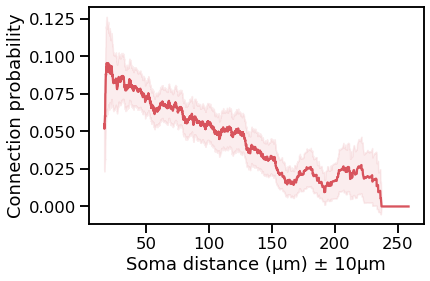

In [8]:
# load precompute proximity data and plot
prox_th100 = pd.read_csv('saved/proximity_th100_avg10um.csv')
plot_somadist_p(prox_th100, avg_th=10, fname="th100/proximity_th100_somadist_p")

### 3. Compute Degree Sequences

In [9]:
# in-degree sequence
aic = np.array([g_th100.in_degree(n) for n in g_th100.nodes()])
# out-degree sequence
aoc = np.array([g_th100.out_degree(n) for n in g_th100.nodes()])

### 4. Compare the Degree Distribution with Proximity-Based Random Graph

In [10]:
%%time
# sample degree sequences from proximity model, n=100
g_complete = nx.complete_graph(g_th100.nodes(), nx.DiGraph())
ric_sample, roc_sample = prox_sample_degs(g_complete, prox_th100["p_connect"], prox_th100["edge_order"])

CPU times: user 552 ms, sys: 0 ns, total: 552 ms
Wall time: 1.12 s


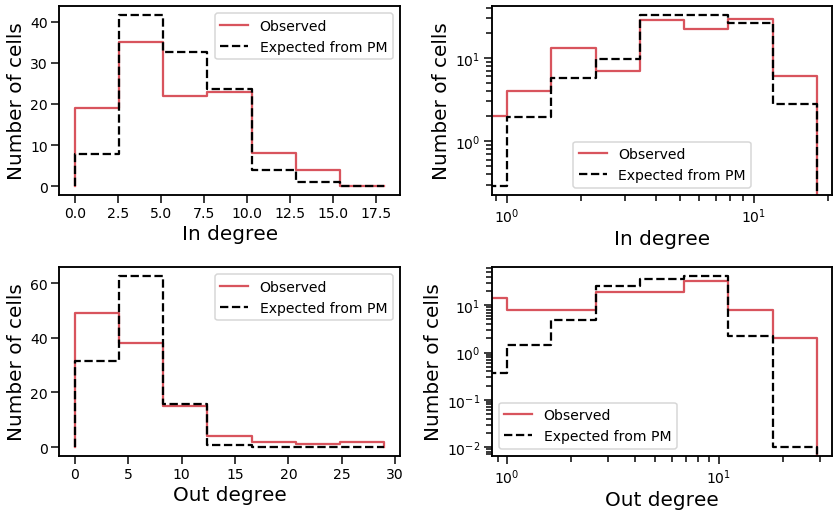

In [12]:
overlay_hists_log([aic, ric_sample], 
                  [aoc, roc_sample], 
                  ['Observed', 'Expected from PM'], 
                  ['Observed', 'Expected from PM'], 
                  title='', density=False, fname="th100/proximity_th100_degree_distribution")